In [243]:
# import

import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from urllib.request import urlopen
import json
import re
import os
import pandas as pd
import datetime as dt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.lines as mlines
from urllib.request import urlopen
from bs4 import BeautifulSoup
from functools import reduce
from collections import OrderedDict
from datetime import date

In [244]:
# define function: get all WIGOS identifier

def get_WIGOS_ID_country(country):

    """ use the OSCAR API to find all stations registered within one country

    Parameters:
        country (str): country code - e.g. KEN for Kenya

    Returns:
        wigosIds (list): list of all WIGOS IDs of registered stations in selected country
    """    

    # open API
    all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName=" + country
    response = urlopen(all_stations_KEN_url)
    data_json = json.loads(response.read())

    # find WIGOS IDs and save in list
    wigosIds = []
    for station in data_json["stationSearchResults"]:
        wigosId = str(station["wigosId"])
        wigosIds.append(wigosId)
    
    return wigosIds


In [245]:
# define function: get xml files

def get_xml_info(WIGOS_ID):

    """get xml information through jOAI and save file
    """    

    # open xml file thorugh jOAI
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + str(id)
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')
    content = soup('OAI-PMH')

    # save file
    with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
        f.write(str(content))
    

In [246]:
# define function: find necessary information and create data frame

def get_information_date_verification(country):

    """ create data frame with the required information (station, establishment date and start of first deployment) from the underlying xml files 

    Parameters:
        country (str): country code - e.g. KEN for Kenya

    Returns:
        df_dates (data frame): ata frame with the required information (station, establishment date and start of first deployment)
    """    

    # prepare data frame
    df_dates = pd.DataFrame(np.nan, index=[0],columns=["station", "dateEstablished", "firstDeploymentStart"])

    # get WIGOS IDs
    wigosIds = get_WIGOS_ID_country(country)

    # go through each station xml and append the information to the data frame
    for id in wigosIds:
        print(id)
        get_xml_info(id)

        # open xml
        observedProperties = []
        url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + str(id)
        xml = urlopen(url).read()
        soup = BeautifulSoup(xml, 'xml')


        # find establishment date of station
        dateEstablished = soup.find_all('dateEstablished')
        if dateEstablished:
            dateEstablished = re.findall(r'\d{4}-\d{2}-\d{2}',str(dateEstablished))[0]
        else: 
            dateEstablished = "unknown"

        # find observed properties
        with open(os.getcwd()+"/Files/File_"+id+".txt") as myFile:
            observedProperties_line = soup.find_all('observedProperty')
            observedProperties_notation = re.findall(r'\d+',str(observedProperties_line))
            observedProperties.append(observedProperties_notation)

        #  list of unique observed properties 
        def unique(list1):
            ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
            return(ans)
        variables_u = unique(observedProperties[0])

        f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
        lines=f.readlines()

        # find deployment start for every measured variable
        positions = []
        for var in variables_u:
            variable = var

            # find line numbers containing the WMDR notation of the observed property
            numbers = []

            with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
                for num, line in enumerate(myFile, 1):
                    if variable in line:
                        numbers.append(num)

            # find the line numbers with <om:observedProperty
            obs = "observedProperty"
            numbers_obs = []

            for n in numbers:
                if obs in lines[n-1]:
                    number = re.findall(r'\d+',lines[n-1])
                    if number[0]==str(var):
                        numbers_obs.append(n)

            # read 30 lines before "observedProperty" line to get "beginPosition"
            for n in numbers_obs:
                start = "beginPosition"
                line_numbers = range(n-30,n)
                for n in line_numbers:
                    if start in lines[n]:
                        beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                        if beginning:
                            pd.to_datetime(beginning, format='%Y-%m-%d')
                            positions.append(beginning[0])
                        else:
                            positions.append(np.nan)

        # find first date
        pos = pd.to_datetime(positions, format='%Y-%m-%d')
        firstDeploymentStart = pd.Series(pos).min() 
        
        # write data in data frame
        new_row = {"station":id,"dateEstablished":dateEstablished,"firstDeploymentStart":firstDeploymentStart}
        df_dates.loc[len(df_dates)] = new_row 

    df_dates.drop([0], axis=0, inplace=True)

    return df_dates


In [248]:
# define function: create date verification plot


def plot_date_verification(country):

    """ create plot showing the establishment date and the date of the beginning of the first deployment for each station within a country
    """    

    # get stations
    wigosIds = get_WIGOS_ID_country(country)

    # get establishment date and date of the beginning of the first deployment for each station
    df_dates = get_information_date_verification(country)

    # define plot
    plt.style.use('default')
    fig, axes = plt.subplots(1,1, figsize=(14,30))

    # set names and color them according to issues    
    names = []
    # If the establishment date is after the date of the first deployment, the station label appears in red
    warnings_red = []
    # If the establishment date is before the date of the first deployment but does not correspond to it, the station label appears in orange
    warnings_orange = []
    # If the start date of the deployment is missing, the station label appears in yellow
    warnings_yellow = []

    for id in range(0,len(wigosIds)):
        # information to station
        df_var = df_dates[df_dates["station"]==str(wigosIds[id])]
        # background lines for better overview
        plt.hlines(y=id, xmin=min(pd.to_datetime(df_dates["dateEstablished"])), xmax=pd.Timestamp.today(), linewidth=0.1, color="black")
        # line between establishment date and date of beginning of the first deployment
        # x_values = [pd.to_datetime(df_var["dateEstablished"]), pd.to_datetime(df_var["firstDeploymentStart"])]
        # plt.plot(x_values, [id,id], linestyle="--", color="black", label="difference")
        # triangle indicating establishment date
        plt.plot([pd.to_datetime(df_var["dateEstablished"])], [id], marker=">", linestyle='None', color="red", label="establishment")
        # dot indicating date of beginning of the first deployment
        plt.plot([pd.to_datetime(df_var["firstDeploymentStart"])], [id], marker="o",linestyle='None', color="blue", label = "first deployment")
        # station name
        name = str(df_var.iloc[0]["station"])
        names.append(name)
        # color station name according to existing issues
        # red
        if ((pd.to_datetime(df_var.iloc[0]["dateEstablished"])) > (pd.to_datetime(df_var.iloc[0]["firstDeploymentStart"]))):
            warnings_red.append(id)
        # yellow
        elif pd.isnull(pd.to_datetime(df_var.iloc[0]["firstDeploymentStart"])):
            warnings_yellow.append(id)
        # orange
        elif ((pd.to_datetime(df_var.iloc[0]["dateEstablished"])) != (pd.to_datetime(df_var.iloc[0]["firstDeploymentStart"]))):
            warnings_orange.append(id)

    # xlim
    plt.xlim(min(pd.to_datetime(df_dates["dateEstablished"])), xmax=pd.Timestamp.today())

    # set yticklabels
    n = range(0,len(names))
    plt.yticks(n,names)

    # color of yticklabels
    for i in warnings_red: 
        plt.gca().get_yticklabels()[i].set_color("red")
    for i in warnings_orange: 
        plt.gca().get_yticklabels()[i].set_color("orangered")
    for i in warnings_yellow: 
        plt.gca().get_yticklabels()[i].set_color("gold")

    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper left")

    # set title
    plt.title("Establishment date vs. first deployment"+ ' (status on ' + pd.Timestamp.today().strftime("%Y-%m-%d") + ')', fontsize=16, fontweight="bold")

    # save plot to folder with today's date
    date_today = date.today()
    date_today.strftime("%m_%d_%Y")

    # check if directory exists, otherwise create
    dir = os.getcwd()+"/Plots/"+str(date_today)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # save figure
    fig.savefig(dir + "/EstablishmentDate_vs_FirstDeployment_"+str(date_today)+"_.jpeg", bbox_inches='tight')

0-404-300-301570787AS00074
0-404-300-402261127AS63663
0-404-300-271440721AS00049
0-404-300-281480740AS00057
0-404-300-160800395AS00001
0-404-0-63707
0-404-300-392191090AS63662
0-404-0-63721
0-404-300-040200100AS00113
0-404-300-040200098AS00112
0-404-300-301620807AS00073
0-404-300-301580790AS00071
0-404-300-402251125AS00038
0-404-300-402281141AS00036
0-404-300-402291146AS00033
0-404-300-392181085AS63660
0-404-300-361950974AS00015
0-20000-0-63741
0-404-300-472781389AS63747
0-404-300-100470235AS00114
0-404-300-372081037AS00024
0-404-300-372000999AS00025
0-404-300-372031019AS00022
0-404-300-372101048AS00026
0-20000-0-63688
0-404-300-63686
0-20000-0-63720
0-404-0-63719
0-404-300-341870932AS00005
0-404-300-341840918A00001
0-404-300-050210101AS00090
0-404-0-63670
0-20000-0-63723
0-404-300-190950473AS00101
0-404-300-060230111AS00047
0-404-300-190950476AS00099
0-404-300-070320150AS00107
0-404-300-160810398AS0001
0-404-300-160810398AS00009
0-404-300-070320160AS00106
0-20000-0-63740
0-20000-0-636

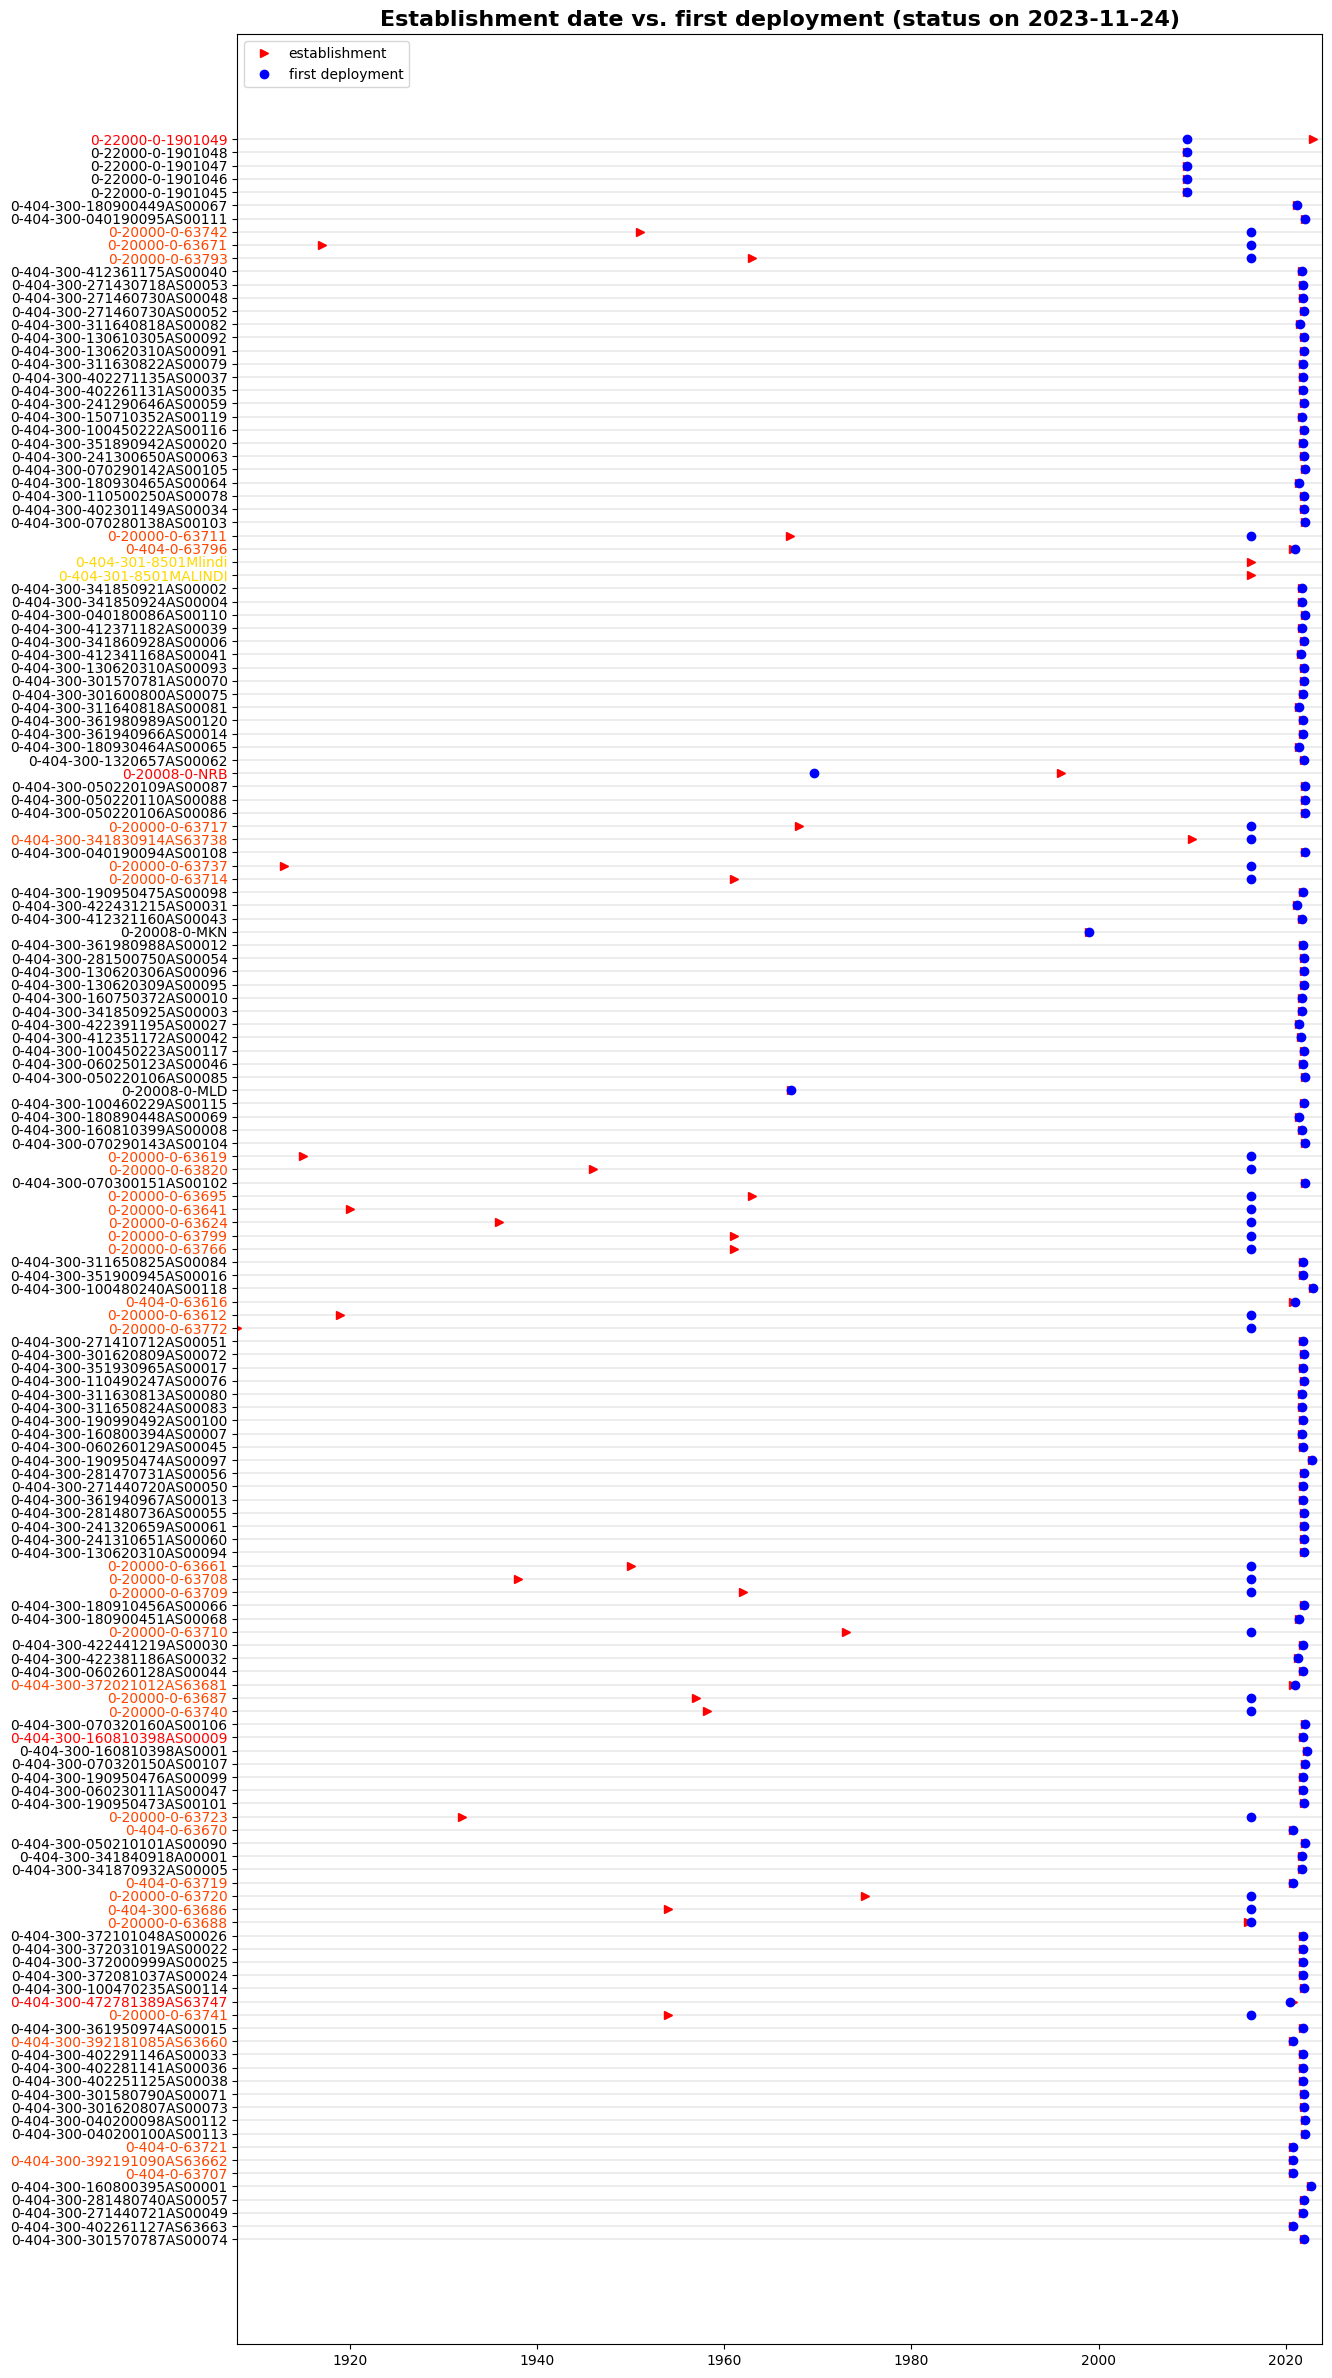

In [249]:
# execute function
plot_date_verification(country="KEN")
